# Lab: Backdoor Attacks

## Creating a backdoor detector for BadNets trained on the YouTube Face dataset through pruning defense.

In [1]:
#imports
import os
import tarfile
import requests
import re
import sys
import warnings

import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

warnings.filterwarnings('ignore')


Define function to load the data

In [2]:
# load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

The cell below downloads the data to drive if colab is used:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


We will be using the clean validation data (valid.h5) from cl folder to design the defense and clean test data (test.h5 from cl folder) and  sunglasses poisoned test data (bd_test.h5 from bd folder) to evaluate the models.

In [4]:
data_path ="/content/gdrive/MyDrive/Colab Notebooks/data/Lab4"

We define the corresponding arrays to store the clean/badnet validation/test data:

In [5]:
poisoned_valid_data_file = data_path+"/bd/bd_valid.h5"
clean_valid_data_file = data_path+"/cl/valid.h5"
poisoned_test_data_file = data_path+"/bd/bd_test.h5"
clean_test_data_file = data_path+"/cl/test.h5"


Read the data:

In [6]:
# Loading data for validation set
clean_valid_features, clean_valid_labels = data_loader(clean_valid_data_file)
poisoned_valid_features, poisoned_valid_labels = data_loader(poisoned_valid_data_file)

# Loading data for test set
clean_test_features, clean_test_labels = data_loader(clean_test_data_file)
poisoned_test_features, poisoned_test_labels = data_loader(poisoned_test_data_file)

Plotting 10 clean images from dataset

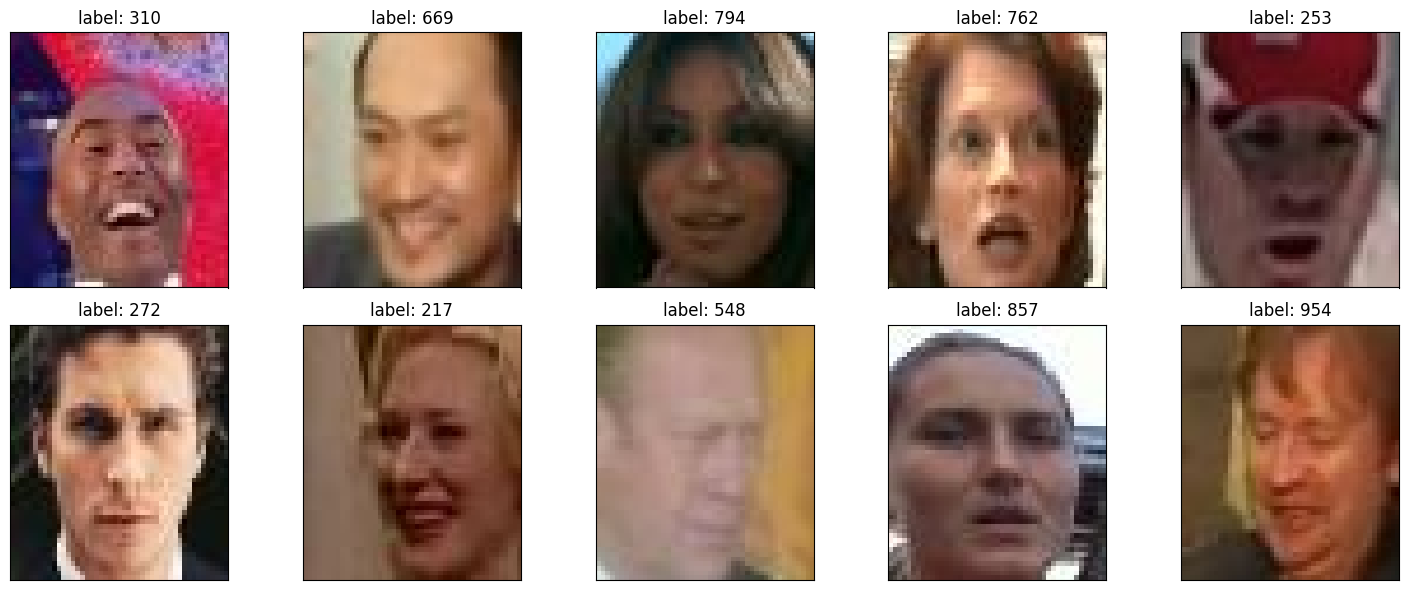

In [7]:
num_images = 10
np.random.seed(0)
random_indices = [np.random.randint(10000) for _ in range(num_images)]
num_rows = 2
num_cols = 5  # Plot images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 3*num_rows))

for i in range(num_images):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(clean_valid_features[random_indices[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(clean_valid_labels[random_indices[i]]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Plotting 10 poisoned images from dataset

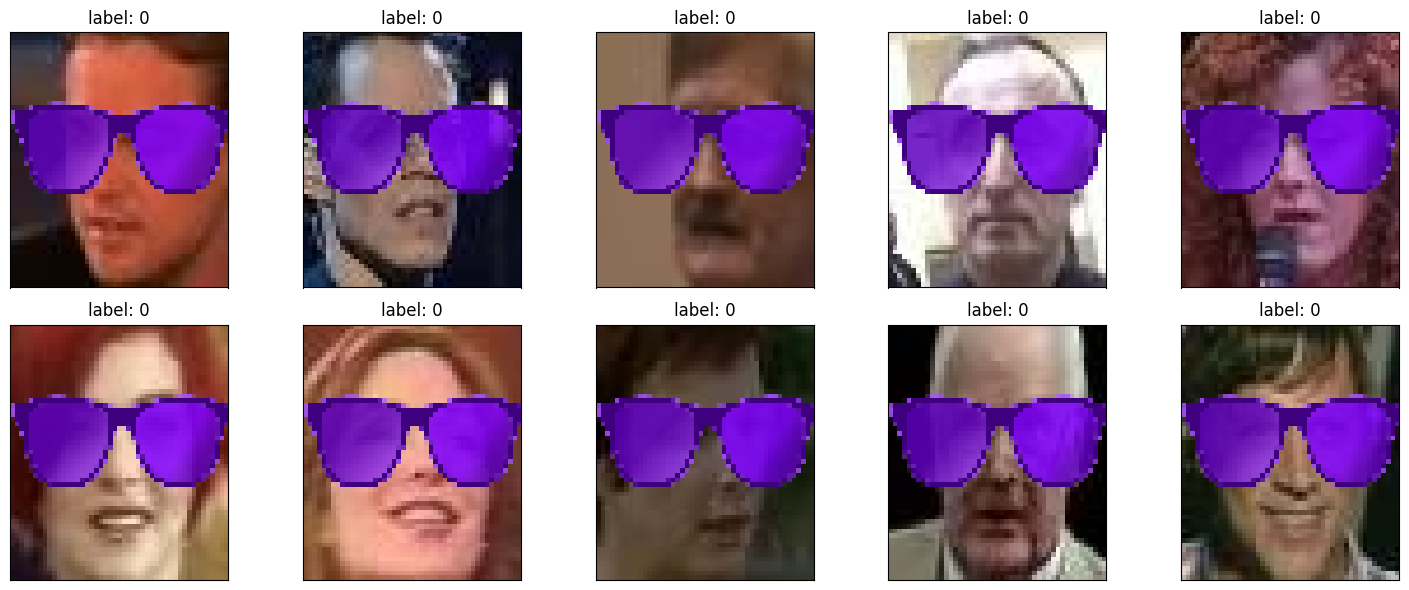

In [8]:
num_images = 10
random_indices = [np.random.randint(10000) for _ in range(num_images)]
num_rows = 2
num_cols = 5  # Plot images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 3*num_rows))

for i in range(num_images):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(poisoned_valid_features[random_indices[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(poisoned_valid_labels[random_indices[i]]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Loading backdoor model and its weights

In [9]:
model = keras.models.load_model(data_path+"/lab3/models/bd_net.h5")
model.load_weights(data_path+"/lab3/models/bd_weights.h5")

## Model Summary

In [10]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

Defining function to get the layer index

In [11]:
def findLayerIndexByName(model, target_layer_name):
    for index, current_layer in enumerate(model.layers):
        if current_layer.name == target_layer_name:
            return index


Retrieve the index of the final pooling layer. We aim to extract activations from this last pooling layer. Use lastConvLayerIdx = findLayerIndexByName(model, "conv_3") to identify the index.

Note that this layer (pool_3) precedes both fc_1 and pool_3 after conv_3, making its index the next one after conv_3.

In [12]:
lastPoolingLayerIndex = findLayerIndexByName(model, "pool_3")
lastPoolingLayerIndex

6

We will be adjusting the channels in the convolutional layer named conv_3, which precedes the final max pooling layer, pool_3.

In [13]:
lastConvLayerIndex = findLayerIndexByName(model, "conv_3")
lastConvLayerIndex


5

Revise the model to produce output immediately following the last pooling layer, denoted as "pool_3".

In [14]:
temporary_model = Model(inputs=model.inputs, outputs=model.layers[lastPoolingLayerIndex].output)
temporary_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 55, 47, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 52, 44, 20)        980       
                                                                 
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 20, 40)        7240      
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 10, 40)        0         
                                                                 
 conv_3 (Conv2D)             (None, 10, 8, 60)         21660     
                                                                 
 pool_3 (MaxPooling2D)       (None, 5, 4, 60)          0     

Retrieve the feature map for the final pooling layer ("pool_3") using the clean validation data.

In [15]:
feature_maps_clean = temporary_model(clean_valid_features)
average_activations_clean = np.mean(feature_maps_clean, axis=0)

Retrieve the feature map for the final pooling layer ("pool_3") using the poisoned validation data.

In [16]:
feature_maps_poisoned = temporary_model(poisoned_valid_features)
average_activations_poisoned = np.mean(feature_maps_poisoned, axis=0)

We will exclusively utilize clean validation data (valid.h5) for crafting the pruning defense. Initially, we compute the average of all poisoned activations within each channel (neuron) and arrange them in ascending order.

In [17]:
average_activations_by_channels = np.mean(np.abs(feature_maps_clean), axis=(0, 1, 2))
indices_to_prune = np.argsort(np.abs(average_activations_by_channels))  # sorted in increasing order

Retrieve the weights and biases of the conv_4 layer from the original network, which will be utilized for pruning.

In [18]:
weights_last_conv_layer = model.layers[lastConvLayerIndex].get_weights()[0]
biases_last_conv_layer = model.layers[lastConvLayerIndex].get_weights()[1]

The accuracy result of the original BadNet on the validation data.

In [19]:
# Create duplicates of the original badnet model (reload from the drive to preserve the original model)
# The resulting repaired model will be denoted as B_prime

B = keras.models.load_model(data_path+"/lab3/models/bd_net.h5")
B.load_weights(data_path+"/lab3/models/bd_weights.h5")

B_prime = keras.models.load_model(data_path+"/lab3/models/bd_net.h5")
B_prime.load_weights(data_path+"/lab3/models/bd_weights.h5")

# Obtain the accuracy of the original badnet model on the validation data
clean_labels_predicted = np.argmax(B(clean_valid_features), axis=1)
clean_accuracy = np.mean(np.equal(clean_labels_predicted, clean_valid_labels)) * 100

# Obtain the success rate of the original badnet model on the validation data
poisoned_labels_predicted = np.argmax(B(poisoned_valid_features), axis=1)
attack_success_rate = np.mean(np.equal(poisoned_labels_predicted, poisoned_valid_labels)) * 100

print("Clean validation accuracy before modification: {0:3.6f}, attack success rate: {1:3.6f}".format(clean_accuracy, attack_success_rate))
K.clear_session()

Clean validation accuracy before modification: 98.649000, attack success rate: 100.000000


Iterate through all indices for pruning and save models if the validation accuracy falls below {2%, 4%, 10%} of the current accuracy.

In [20]:
total_percent_channels_removed = np.zeros((60))
total_clean_accuracy_valid = np.zeros((60))
total_attack_success_rate_valid = np.zeros((60))
total_clean_accuracy_test = np.zeros((60))
total_attack_success_rate_test = np.zeros((60))
percent_validation_accuracy = []
is_model_saved = [0, 0, 0]  # Flags to check if the model has been saved.

# The first flag is for saving the model when validation accuracy drops below 2%,
# the second is for 4%, and the third is for 10%.

iteration = 0
for channel_index in indices_to_prune:
    # Remove one channel at a time
    weights_last_conv_layer[:, :, :, channel_index] = 0
    biases_last_conv_layer[channel_index] = 0

    # Update weights and biases of the repaired badnet
    B_prime.layers[lastConvLayerIndex].set_weights([weights_last_conv_layer, biases_last_conv_layer])

    # Evaluate the updated model predictions on the clean validation data
    cl_label_p_valid = np.argmax(B_prime(clean_valid_features), axis=1)
    clean_accuracy_valid = np.mean(np.equal(cl_label_p_valid, clean_valid_labels)) * 100

    if (clean_accuracy - clean_accuracy_valid) / clean_accuracy * 100 >= 2 and not is_model_saved[0]:
        B_prime.save(data_path + '/repaired_models/bd_repaired_2.h5')
        B_prime.save_weights(data_path + '/repaired_models/bd_repaired_2_weights.h5')
        print("Validation accuracy dropped 2% below the original accuracy. Model has been saved as bd_repaired_2.h5")
        percent_validation_accuracy.append(clean_accuracy_valid)
        is_model_saved[0] = 1
    if (clean_accuracy - clean_accuracy_valid) / clean_accuracy * 100 >= 4 and not is_model_saved[1]:
        B_prime.save(data_path + '/repaired_models/bd_repaired_4.h5')
        B_prime.save_weights(data_path + '/repaired_models/bd_repaired_4_weights.h5')
        print("Validation accuracy dropped 4% below the original accuracy. Model has been saved as bd_repaired_4.h5")
        percent_validation_accuracy.append(clean_accuracy_valid)
        is_model_saved[1] = 1
    if (clean_accuracy - clean_accuracy_valid) / clean_accuracy * 100 >= 10 and not is_model_saved[2]:
        B_prime.save(data_path + '/repaired_models/bd_repaired_10.h5')
        B_prime.save_weights(data_path + '/repaired_models/bd_repaired_10_weights.h5')
        print("Validation accuracy dropped 10% below the original accuracy. Model has been saved as bd_repaired_10.h5")
        percent_validation_accuracy.append(clean_accuracy_valid)
        is_model_saved[2] = 1

    # Evaluate the updated model attack success rate on the validation data
    bd_label_p_valid = np.argmax(B_prime(poisoned_valid_features), axis=1)
    asr_valid = np.mean(np.equal(bd_label_p_valid, poisoned_valid_labels)) * 100

    # Evaluate the updated model accuracy on the clean test data
    cl_label_p_test = np.argmax(B_prime(clean_test_features), axis=1)
    clean_accuracy_test = np.mean(np.equal(cl_label_p_test, clean_test_labels)) * 100

    # Evaluate the updated model attack success rate on the test data
    bd_label_p_test = np.argmax(B_prime(poisoned_test_features), axis=1)
    asr_test = np.mean(np.equal(bd_label_p_test, poisoned_test_labels)) * 100

    percent_channels_removed = (iteration + 1) / weights_last_conv_layer.shape[3]
    print("Iteration = {0:3d}, Channels removed = {1:3d}, Percentage channels removed = {2:3.2f}%\nClean Accuracy: {3:3.2f}%, Accuracy difference: {4:3.2f}%, Attack success rate =  {5:3.2f}%".format(iteration, channel_index, percent_channels_removed * 100,clean_accuracy_valid , (clean_accuracy - clean_accuracy_valid), asr_valid))

    K.clear_session()

    total_percent_channels_removed[iteration] = percent_channels_removed
    total_clean_accuracy_valid[iteration] = clean_accuracy_valid
    total_attack_success_rate_valid[iteration] = asr_valid
    total_clean_accuracy_test[iteration] = clean_accuracy_test
    total_attack_success_rate_test[iteration] = asr_test
    iteration += 1


Iteration =   0, Channels removed =   0, Percentage channels removed = 1.67%
Clean Accuracy: 98.65%, Accuracy difference: 0.00%, Attack success rate =  100.00%
Iteration =   1, Channels removed =  26, Percentage channels removed = 3.33%
Clean Accuracy: 98.65%, Accuracy difference: 0.00%, Attack success rate =  100.00%
Iteration =   2, Channels removed =  27, Percentage channels removed = 5.00%
Clean Accuracy: 98.65%, Accuracy difference: 0.00%, Attack success rate =  100.00%
Iteration =   3, Channels removed =  30, Percentage channels removed = 6.67%
Clean Accuracy: 98.65%, Accuracy difference: 0.00%, Attack success rate =  100.00%
Iteration =   4, Channels removed =  31, Percentage channels removed = 8.33%
Clean Accuracy: 98.65%, Accuracy difference: 0.00%, Attack success rate =  100.00%
Iteration =   5, Channels removed =  33, Percentage channels removed = 10.00%
Clean Accuracy: 98.65%, Accuracy difference: 0.00%, Attack success rate =  100.00%
Iteration =   6, Channels removed =  34

Visualizing the accuracy on clean validation data and the attack success rate (on backdoored validation data) with respect to the proportion of pruned channels.

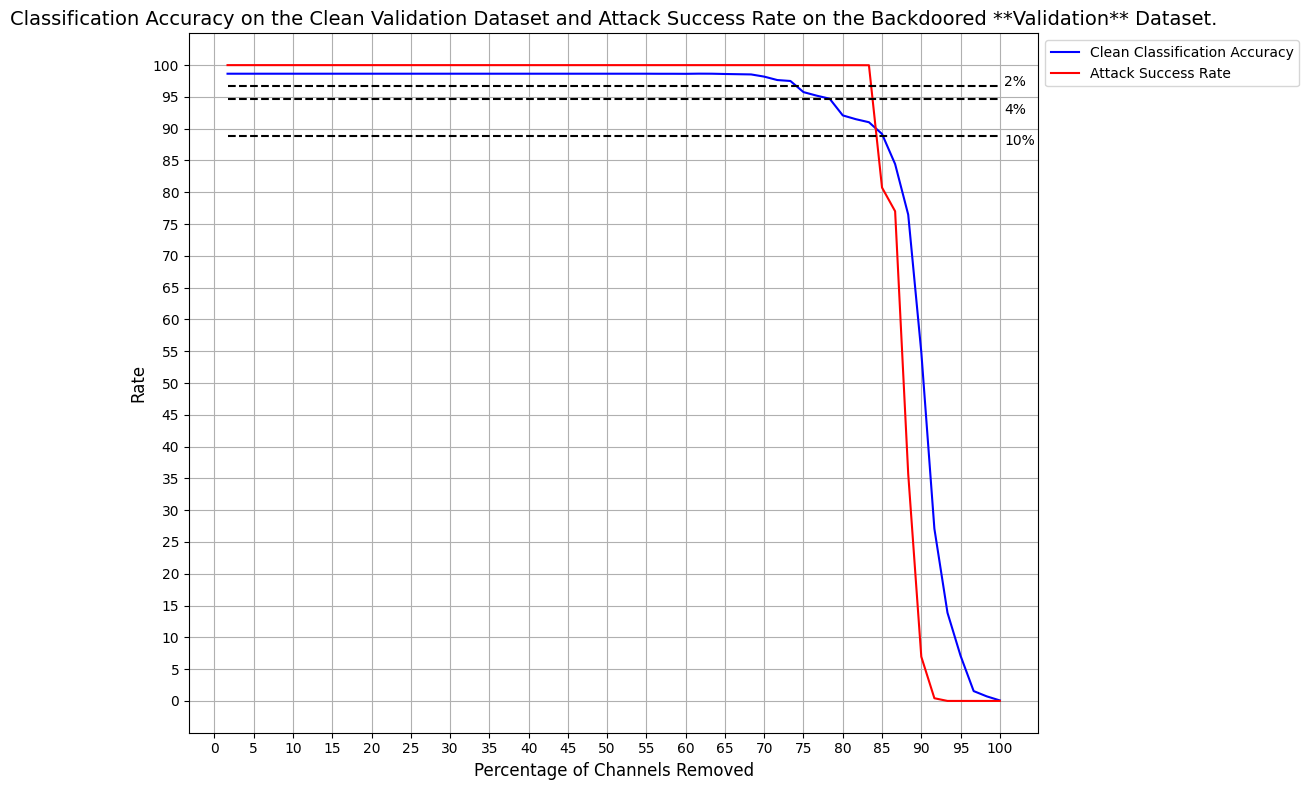

In [21]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_yticks(np.arange(0, 101, 5))
ax.set_xticks(np.arange(0, 101, 5))
ax.set_ylabel('Rate', fontsize=12)
ax.set_xlabel('Percentage of Channels Removed', fontsize=12)
ax.set_title("Classification Accuracy on the Clean Validation Dataset and Attack Success Rate on the Backdoored **Validation** Dataset.", fontsize=14)

# Plot clean classification accuracy and attack success rate
ax.plot(total_percent_channels_removed*100, total_clean_accuracy_valid, 'b-', label="Clean Classification Accuracy")
ax.plot(total_percent_channels_removed*100, total_attack_success_rate_valid, 'r-', label='Attack Success Rate')

# Set legend and plot threshold lines
font = font_manager.FontProperties(size=10)
ax.legend(loc='best', bbox_to_anchor=(1, 1), prop=font)
ax.plot([total_percent_channels_removed[0]*100, total_percent_channels_removed[-1]*100], [clean_accuracy * 0.98, clean_accuracy * 0.98], 'k--')
ax.text(0.96, 0.925, '2%', fontsize=10, transform=ax.transAxes)
ax.plot([total_percent_channels_removed[0]*100, total_percent_channels_removed[-1]*100], [clean_accuracy * 0.96, clean_accuracy * 0.96], 'k--')
ax.text(0.96, 0.885, '4%', fontsize=10, transform=ax.transAxes)
ax.plot([total_percent_channels_removed[0]*100, total_percent_channels_removed[-1]*100], [clean_accuracy * 0.90, clean_accuracy * 0.90], 'k--')
ax.text(0.96, 0.84, '10%', fontsize=10, transform=ax.transAxes)

# Add grid and adjust layout
plt.grid()
fig.tight_layout()
plt.show()


Visualizing the accuracy on clean test data and the attack success rate (on backdoored test data) with respect to the proportion of pruned channels.

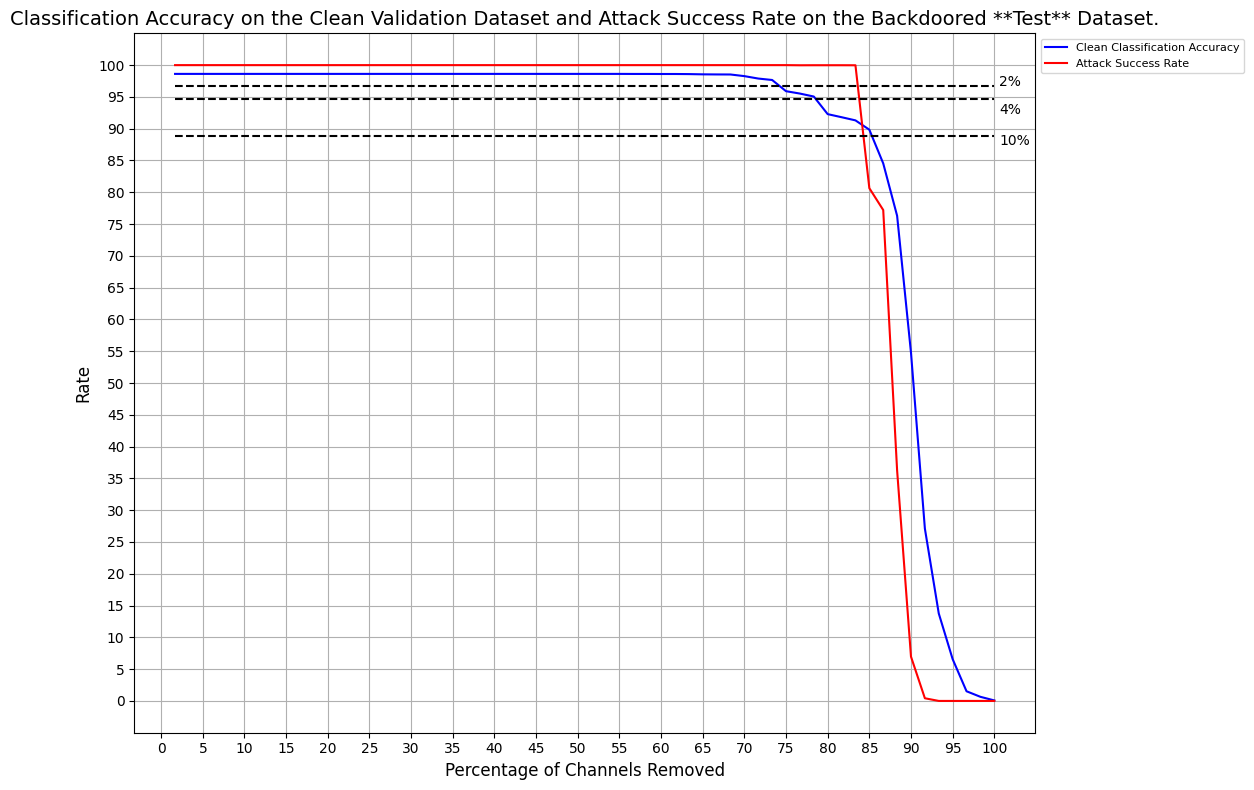

In [22]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_yticks(np.arange(0, 101, 5))
ax.set_xticks(np.arange(0, 101, 5))
ax.set_ylabel('Rate', fontsize=12)
ax.set_xlabel('Percentage of Channels Removed', fontsize=12)
ax.set_title("Classification Accuracy on the Clean Validation Dataset and Attack Success Rate on the Backdoored **Test** Dataset.", fontsize=14)

# Plot clean classification accuracy and attack success rate
ax.plot(total_percent_channels_removed*100, total_clean_accuracy_test, 'b-', label="Clean Classification Accuracy")
ax.plot(total_percent_channels_removed*100, total_attack_success_rate_test, 'r-', label='Attack Success Rate')

# Set legend and plot threshold lines
font = font_manager.FontProperties(size=8)
ax.legend(loc='best', bbox_to_anchor=(1, 1), prop=font)
ax.plot([total_percent_channels_removed[0]*100, total_percent_channels_removed[-1]*100], [clean_accuracy * 0.98, clean_accuracy * 0.98], 'k--')
ax.text(0.96, 0.925, '2%', fontsize=10, transform=ax.transAxes)
ax.plot([total_percent_channels_removed[0]*100, total_percent_channels_removed[-1]*100], [clean_accuracy * 0.96, clean_accuracy * 0.96], 'k--')
ax.text(0.96, 0.885, '4%', fontsize=10, transform=ax.transAxes)
ax.plot([total_percent_channels_removed[0]*100, total_percent_channels_removed[-1]*100], [clean_accuracy * 0.90, clean_accuracy * 0.90], 'k--')
ax.text(0.96, 0.84, '10%', fontsize=10, transform=ax.transAxes)

# Add grid and adjust layout
plt.grid()
fig.tight_layout()
plt.show()

#plt.savefig('FIGURES/totalAccuracySr_test_conv3.pdf')
#plt.savefig('FIGURES/totalAccuracySr_test_conv3.png', dpi=400)

From these visualizations, we can observe a significant decrease in the backdoor attack success rate when a large portion of neurons is pruned. Initially, the attack success rate hovers around 100%, while the clean classification accuracy remains stable. This can be explained as follows: initially, we prune neurons that are either all zeros or poorly activated, making them irrelevant to both a genuine network and a malicious badnet.

As the number of channels removed exceeds 70% but remains below 83% of their initial quantity, we observe a decline in clean classification accuracy. This suggests that we are now pruning neurons responsible for classifying clean inputs but not those activated by malicious inputs. Beyond 83% of all neurons removed, both the attack success rate and clean classification accuracy experience a drop. This indicates that we are now removing neurons activated by both clean and malicious inputs.

It's noteworthy that complete elimination of the backdoor attack is challenging since doing so would lead to a decline in clean classification accuracy. For instance, reducing the attack success rate to 6% by disabling 90% of neurons results in a significant decrease in clean classification accuracy to almost 50%.



Now, the task is to integrate the models into a repaired goodnet G, which correctly outputs the class for clean inputs and class N+1 for backdoored inputs. One approach is to "subclass" the models in Keras.

In [23]:
class G(tf.keras.Model):
    def __init__(self, original_model, repaired_model):
        super(G, self).__init__()
        self.original_model = original_model
        self.repaired_model = repaired_model

    def predict(self, input_data):
        predictions_original = np.argmax(self.original_model(input_data), axis=1)
        predictions_repaired = np.argmax(self.repaired_model(input_data), axis=1)
        temp_result = np.array([predictions_original[i] if predictions_original[i] == predictions_repaired[i] else 1283 for i in range(predictions_original.shape[0])])
        result = np.zeros((predictions_original.shape[0], 1284))
        result[np.arange(temp_result.size), temp_result] = 1
        return result

    def call(self, input_data):
        predictions_original = np.argmax(self.original_model(input_data), axis=1)
        predictions_repaired = np.argmax(self.repaired_model(input_data), axis=1)
        temp_result = np.array([predictions_original[i] if predictions_original[i] == predictions_repaired[i] else 1283 for i in range(predictions_original.shape[0])])
        result = np.zeros((predictions_original.shape[0], 1284))
        result[np.arange(temp_result.size), temp_result] = 1
        return result


Load the saved B_prime models

In [24]:
B_prime_2  = keras.models.load_model(data_path+"/repaired_models/bd_repaired_2.h5")
B_prime_2.load_weights(data_path+"/repaired_models/bd_repaired_2_weights.h5")

B_prime_4  = keras.models.load_model(data_path+"/repaired_models/bd_repaired_4.h5")
B_prime_4.load_weights(data_path+"/repaired_models/bd_repaired_4_weights.h5")

B_prime_10  = keras.models.load_model(data_path+"/repaired_models/bd_repaired_10.h5")
B_prime_10.load_weights(data_path+"/repaired_models/bd_repaired_10_weights.h5")

Evaluate the performance of the repaired models on the test dataset:


In [25]:
cl_label_p_B_2 = np.argmax(B_prime_2.predict(clean_valid_features), axis=1)
clean_accuracy_B_2 = np.mean(np.equal(cl_label_p_B_2, clean_valid_labels)) * 100
print('Clean Classification accuracy for B_prime_2:', clean_accuracy_B_2)

bd_label_p_B_2 = np.argmax(B_prime_2.predict(poisoned_valid_features), axis=1)
asr_B_2 = np.mean(np.equal(bd_label_p_B_2, poisoned_valid_labels)) * 100
print('Attack Success Rate for B_prime_2:', asr_B_2)

cl_label_p_B_4 = np.argmax(B_prime_4.predict(clean_valid_features), axis=1)
clean_accuracy_B_4 = np.mean(np.equal(cl_label_p_B_4, clean_valid_labels)) * 100
print('Clean Classification accuracy for B_prime_4:', clean_accuracy_B_4)

bd_label_p_B_4 = np.argmax(B_prime_4.predict(poisoned_valid_features), axis=1)
asr_B_4 = np.mean(np.equal(bd_label_p_B_4, poisoned_valid_labels)) * 100
print('Attack Success Rate for B_prime_4:', asr_B_4)

cl_label_p_B_10 = np.argmax(B_prime_10.predict(clean_valid_features), axis=1)
clean_accuracy_B_10 = np.mean(np.equal(cl_label_p_B_10, clean_valid_labels)) * 100
print('Clean Classification accuracy for B_prime_10:', clean_accuracy_B_10)

bd_label_p_B_10 = np.argmax(B_prime_10.predict(poisoned_valid_features), axis=1)
asr_B_10 = np.mean(np.equal(bd_label_p_B_10, poisoned_valid_labels)) * 100
print('Attack Success Rate for B_prime_10:', asr_B_10)



361/361 [==============================] - 1s 3ms/step
Clean Classification accuracy for B_prime_2: 95.75647354291158
361/361 [==============================] - 1s 3ms/step
Attack Success Rate for B_prime_2: 100.0
361/361 [==============================] - 1s 3ms/step
Clean Classification accuracy for B_prime_4: 92.09318437689443
361/361 [==============================] - 1s 3ms/step
Attack Success Rate for B_prime_4: 99.9913397419243
361/361 [==============================] - 1s 2ms/step
Clean Classification accuracy for B_prime_10: 84.43751623798389
361/361 [==============================] - 1s 3ms/step
Attack Success Rate for B_prime_10: 77.015675067117


**Create repaired networks.**

In [26]:
# repaired network for 2% drop below the original accuracy
G_2=G(B, B_prime_2)
# repaired network for 4% drop below the original accuracy
G_4=G(B, B_prime_4)
# repaired network for 10% drop below the original accuracy
G_10=G(B, B_prime_10)

Evaluate the performance of the goodnet models on the test data:

In [27]:
cl_label_p_G_2 = np.argmax(G_2(clean_valid_features), axis=1)
clean_accuracy_G_2 = np.mean(np.equal(cl_label_p_G_2, clean_valid_labels)) * 100
print('Clean Classification accuracy for G_2:', clean_accuracy_G_2)

bd_label_p_G_2 = np.argmax(G_2(poisoned_valid_features), axis=1)
asr_G_2 = np.mean(np.equal(bd_label_p_G_2, poisoned_valid_labels)) * 100
print('Attack Success Rate for G_2:', asr_G_2)

cl_label_p_G_4 = np.argmax(G_4(clean_valid_features), axis=1)
clean_accuracy_G_4 = np.mean(np.equal(cl_label_p_G_4, clean_valid_labels)) * 100
print('Clean Classification accuracy for G_4:', clean_accuracy_G_4)

bd_label_p_G_4 = np.argmax(G_4(poisoned_valid_features), axis=1)
asr_G_4 = np.mean(np.equal(bd_label_p_G_4, poisoned_valid_labels)) * 100
print('Attack Success Rate for G_4:', asr_G_4)

cl_label_p_G_10 = np.argmax(G_10(clean_valid_features), axis=1)
clean_accuracy_G_10 = np.mean(np.equal(cl_label_p_G_10, clean_valid_labels)) * 100
print('Clean Classification accuracy for G_10:', clean_accuracy_G_10)

bd_label_p_G_10 = np.argmax(G_10(poisoned_valid_features), axis=1)
asr_G_10 = np.mean(np.equal(bd_label_p_G_10, poisoned_valid_labels)) * 100
print('Attack Success Rate for G_10:', asr_G_10)



Clean Classification accuracy for G_2: 95.61790941370053
Attack Success Rate for G_2: 100.0
Clean Classification accuracy for G_4: 91.85935740885078
Attack Success Rate for G_4: 99.9913397419243
Clean Classification accuracy for G_10: 84.24699056031871
Attack Success Rate for G_10: 77.015675067117


Plot barplot:

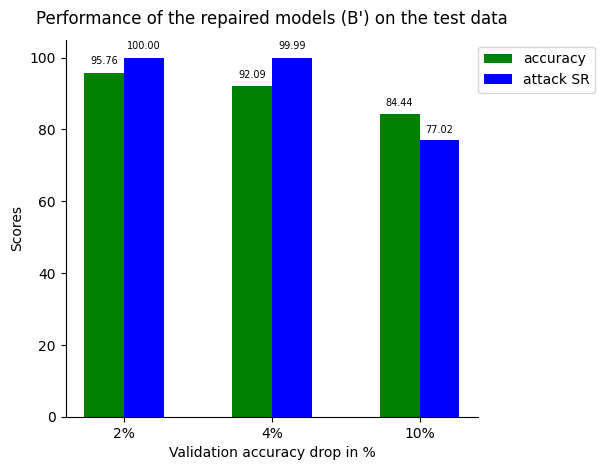

In [28]:
num_categories = 3
category_indices = np.arange(num_categories)  # the x locations for the groups
bar_width = 0.27        # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

clean_accuracy_values = [clean_accuracy_B_2, clean_accuracy_B_4, clean_accuracy_B_10]
rects1 = ax.bar(category_indices, clean_accuracy_values, bar_width, color='g')

attack_success_values = [asr_B_2, asr_B_4, asr_B_10]
rects2 = ax.bar(category_indices + bar_width, attack_success_values, bar_width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(category_indices + bar_width/2)
ax.set_xticklabels(('2%', '4%', '10%'))
ax.legend((rects1[0], rects2[0]), ('accuracy', 'attack SR'), bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
ax.set_title("Performance of the repaired models (B') on the test data", y=1.02)
ax.set_xlabel('Validation accuracy drop in %')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height, '%.2f' % height,
                ha='center', va='bottom', fontsize=7)

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()


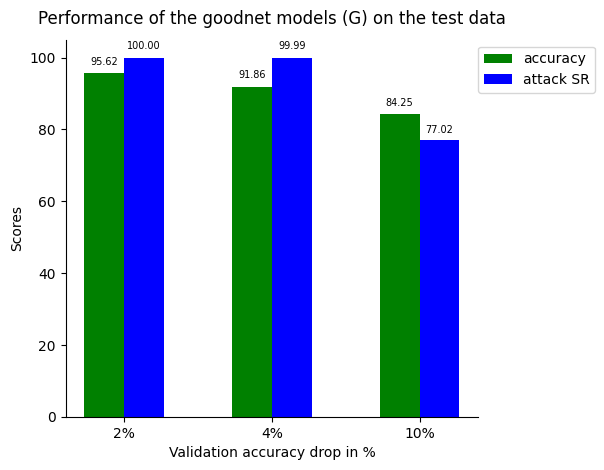

In [29]:
num_categories = 3
category_indices = np.arange(num_categories)  # the x locations for the groups
bar_width = 0.27        # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

clean_accuracy_values_G = [clean_accuracy_G_2, clean_accuracy_G_4, clean_accuracy_G_10]
rects1 = ax.bar(category_indices, clean_accuracy_values_G, bar_width, color='g')

attack_success_values_G = [asr_G_2, asr_G_4, asr_G_10]
rects2 = ax.bar(category_indices + bar_width, attack_success_values_G, bar_width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(category_indices + bar_width/2)
ax.set_xticklabels(('2%', '4%', '10%'))
ax.legend((rects1[0], rects2[0]), ('accuracy', 'attack SR'), bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
ax.set_title("Performance of the goodnet models (G) on the test data", y=1.02)
ax.set_xlabel('Validation accuracy drop in %')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height, '%.2f' % height,
                ha='center', va='bottom', fontsize=7)

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

We observe that the effectiveness of the repairing models is limited, as they often fail to prevent the attack. Specifically, when the validation accuracy drops by 2% and 4% below the original accuracy, the attack success rate tends to dominate over the prediction accuracy. This is attributed to the fact that the repaired badnets (B') still exhibit a 100% success rate. These findings suggest the presence of a pruning-aware attack, wherein the attacker embedded the backdoor behavior into the same neurons used for classifying clean data.

The dynamics change when the validation accuracy drops by 10% below the original accuracy. In this scenario, the validation accuracy surpasses the attack success rate. Nevertheless, given the pruning-aware nature of the attack, where the attacker utilized the same set of neurons used by the original model for classification, removing these neurons leads not only to a decrease in the attack success rate but also to a decline in the accuracy of classifying clean data. This is clearly evident in the bar plots above.

Even when employing a model with almost 90% of neurons pruned (corresponding to a validation accuracy drop of 30% below the original accuracy), the achieved accuracies are only slightly above chance level. This indicates that the pruning defense is not highly effective against this type of attack.

It is noteworthy that the accuracy of Goodnet (G) is slightly lower than that of the repaired networks (B') since it eliminates some labels that were misclassified by the badnet.